# Harry Potter and the Character Analysis

In this book I try to extract all the characters from the Harry Potter novels so that I can analyse their occourences and relations over the course of the novels.

In [1]:
%matplotlib notebook

#functions and import statements
from SPARQLWrapper import SPARQLWrapper, JSON
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def import_characters(verbose=False):
    """Import Harry Potter Characters from WikiData using SPARQL query"""

    ignored_characters = \
    ['Basilisk in the Chamber of Secrets', # The Chamber of Secrets bit artificially enhances presence
     'Fred Weasley II', # George Weasleys son. Does not appear in the books, but clashes with Fred continously
     'Goyle senior', # Goyles' dad. Only appears in one scene, but clashes every time Goyle appears
     'Half-blood Prince', # Double entry. The Half-blood Prince is Severus Snape
     'Heir of Slytherin', # Double entry. This is Voldemort
     'Markus Belby', # Double entry of Marcus Belby
     'Regulus Arcturus Black', # Forefather of Regulus Black. Sirius' brother
     'Sirius Black I', # Forefather of Sirius Black. Difficult to separate from the one who appears in the books
     'Sirius Black II'] # this one is Sirius Black II. Another descendant of the Sirius Black in the books

    # SPARQL query to retrieve list of HP characters
    # query = """
    # SELECT DISTINCT ?item ?itemLabel ?itemAltLabel 
    #     WHERE 
    #     { 
    #          {
    #          ?item wdt:P31 ?sub1 .
    #          ?sub1 (wdt:P279|wdt:P131)* wd:Q95074 . 
    #          ?item wdt:P1080 ?sub2 . 
    #          ?sub2 (wdt:P279|wdt:P131)* wd:Q5410773 
    #          }
    #     OPTIONAL { ?item skos:altLabel ?altLabel . FILTER (lang(?altLabel) = "en") }
    #     SERVICE wikibase:label { bd:serviceParam wikibase:language 'en' . }
    #     }
    #     ORDER BY ?itemLabel
    # """

    query = """
    SELECT DISTINCT ?item ?itemLabel ?itemAltLabel 
        WHERE 
        { 
        {?item wdt:P31/wdt:P279* wd:Q15298221} UNION 
        {?item wdt:P31/wdt:P279* wd:Q154224} UNION
        {?item wdt:P31/wdt:P279* wd:Q15298259} UNION
        {?item wdt:P31/wdt:P279* wd:Q2087138} UNION
        {?item wdt:P31/wdt:P279* wd:Q15298195}.
        OPTIONAL { ?item skos:altLabel ?altLabel . FILTER (lang(?altLabel) = "en") }
        SERVICE wikibase:label { bd:serviceParam wikibase:language 'en' . }
        }
        ORDER BY ?itemLabel
    """

    # set up sparql connection to WikiData
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert() # run query and convert to json

    character_list = [] # initialize character list
    cid = 1
    for result in results["results"]["bindings"]: # loop over results
        # the character label (typically the name)
        label = result['itemLabel']['value']
        # alternative label. Not always present, but includes also known as.
        # Examples:
        #  - Alastor Moody a.k.a. Mad-Eye Moody
        #  - Arthur Weasley a.k.a. Mr. Weasley
        #  - Harry Potter a.k.a. Harry James Potter, The Boy Who Lived
        #  - Voldemort a.k.a. You-Know-Who, Tom Riddle, He-Who-Must-Not-Be-Named
        alt_label = result['itemAltLabel']['value'] if 'itemAltLabel' in result else ''

        if label[1:].isdigit():
            continue # Removes instances that are Q[number]. These are erroneous in WikiData

        # characters that I have manually decided to ignore
        if label in ignored_characters:
            continue

        # For each character I create a list of words associated with that character.
        # These words include the character name and a.k.a.
        # I remove stop words from the list of associated words (e.g. the in Beedle the Bard)
        # I also try to identify each character's first name (E.g. Harry, Hermione, Ron). I remove
        # prefixes like Mr., Mrs., and Sir.
        # Each character also gets the first letter from their first name associated with them (e.g.
        # H. for H. Potter)

        associated_words = label.split(' ') + [label[0]+'.']
        if alt_label:
            for aka in alt_label.split(', '):
                for word in aka.split(' '):
                    # if present remove quotes in word (sometimes used for nicknames)
                    associated_words += [word.replace('"', '').replace("'", "")]
        # make all associated words lowercase
        associated_words = [word.lower() for word in associated_words]
        # remove stopwords from associated words
        associated_words = [word for word in associated_words
                            if word not in nltk.corpus.stopwords.words('english')+['sir']]

        # identify character's first name
        first_name = associated_words[0] \
                     if associated_words[0] not in ['mr.', 'mrs.', 'sir'] \
                     else None

        # make associated words into set
        associated_words = set(associated_words)

        # make dict and append to characters list
        cdict = dict(cid=cid,
                     label=label,
                     associated_words=associated_words,
                     first_name=first_name)
        if verbose:
            print('id: {cid}. Character: {label}. First name: {first_name}. Associated Words: {associated_words}'.format(**cdict))
        character_list.append(cdict)
        cid += 1

    return character_list

def character_appearance_in_text(tokens, character_list, verbose=False):
    """Searches for words associated with each character amongst the token.
    If there is match the token and the character becomes associated.
    The algorithm is greedy in the sense that one tokens can be associated with
    several characters.
    The result is a matrix that maps tokens and characters. I make two matrices:
    One for all the words associated with the character, and one only for the
    first name.

    There are two circumstances where characters from import_characters are not
    included in the matrices:
      1. If they are not matched with any tokens
      2. If they are members of the Black, Malfoy, or Weasley family and their
         first name is not matched with any tokens.
    """

    character_appearance_list = []
    first_name_list = []
    for i, character in enumerate(character_list):
        # find tokens that can be associated with a character
        character_appearance = pd.Series(
            tokens.lower.apply(lambda x: x in character['associated_words']).astype(bool),
            index=tokens.index
            )
        # character names always begins with a capital letter. Checking for this avoids instances
        # where a character name is mistaken for regular word (e.g. Crouch in Barty Crouch)
        character_appearance = character_appearance & tokens.capital
        character_appearance.name = character['label']

        # do not include if character is not associated with any tokens
        casum = character_appearance.sum()
        if casum == 0:
            continue

        # find tokens that can be associated with a character's first name
        first_name_appearance = pd.Series(
            tokens.lower.apply(lambda x: x == character['first_name']).astype(bool),
            index=tokens.index
            )
        # character names always begins with a capital letter. Checking for this avoids instances
        # where a character name is mistaken for regular word (e.g. Crouch in Barty Crouch)
        first_name_appearance = first_name_appearance & tokens.capital
        first_name_appearance.name = character['label']

        # do not include if first_name is not associated with any token and character is a member
        # of the Black, Malfoy, or Weasley family
        fnsum = first_name_appearance.sum()
        if fnsum == 0:
            if character['associated_words'].intersection(['black', 'malfoy', 'weasley']):
                continue

        # add character_appearance and first_name_appearance to lists
        character_appearance_list.append(character_appearance)
        first_name_list.append(first_name_appearance)

        if verbose:
            print("{}. Character: {}. First name count: {}. Token count: {}".format(i,
                character['label'], fnsum, casum))

    character_appearances_df = pd.concat(character_appearance_list, axis=1)
    first_names_df = pd.concat(first_name_list, axis=1)

    return first_names_df, character_appearances_df

def mixed_characters(matrix):
    """Given character matrix, return overview over characters that are most often confused with
    each other
    """
    index, = np.where(matrix.sum(axis=1) > 1)
    mixed = []

    character_labels = matrix.columns.values

    for i in index:
        mixed.append(', '.join(character_labels[matrix.iloc[i].values]))

    return pd.Series(mixed, index=index)

def kernel(size, kind='triangular'):
    """Kernel function to help the character scoring"""
    if size % 2 == 0:
        raise ValueError("Kernel length must be odd")

    u = np.linspace(-1, 1, size)

    if kind == 'triangular':
        k = 1 - np.abs(u)
    elif kind == 'parabolic':
        k = 3/4*(1 - u**2)

    return k

def score_characters(text_matrix, first_name_matrix, character_matrix, dx=6, kind='triangular',
                     verbose=False):
    """Given character matrices, score each token to help determine which character it refers to.
    The scoring is done by lookint at a small section of tokens surrounding the central token, and
    labelling the characters the surrounding tokens refer to. A triangular kernel is used so that
    tokens close to the main token are weighted higher.
    If the main token is mr., mrs. or professor the following token is assigned a higher weight.
    If a token is in the first_name_matrix it is added the character_matrix with a weight of 0.2
    """

    k = kernel(2*dx+1, kind=kind) # kernel for score weights
    indices, = np.where(character_matrix.sum(axis=1) > 1) # tokens with more than one candidate character

    tokens = text_matrix.lower.astype(str)

    score_list = []
    for i, index in enumerate(indices): # loop over indices
        if verbose:
            print(i, index, indices.size)

        # incides around central token
        df_index = np.arange((index-dx), (index+dx+1), dtype=np.int)

        # weights array
        weight = np.ones(2*dx+1, dtype=np.float)
        for j in range(1, 2*dx+1):
            if tokens[df_index[j-1]][-1] == '.':
                weight[j] = 1.5
            if tokens[df_index[j-1]] == 'professor':
                weight[j] = 1.5

        factor = weight*k

        # apply weights
        score = (factor[:, np.newaxis]*character_matrix.iloc[df_index]).sum()
        score += 0.2*first_name_matrix.iloc[df_index].sum()

        score_list.append(score)

    score_df = pd.concat(score_list, axis=1).T
    score_df.index = indices

    return score_df

def popularity_contest(character_matrix, verbose=False):
    """Decide candidate characters by who appears the most times"""

    counts = character_matrix.sum(axis=0)
    # Some counts are enhanced artificially to make sure the final order
    # is right
    counts['Draco Malfoy'] += 100 
    counts['Nymphadora Tonks'] += 100
    counts['James Potter'] += 100

    character_labels = counts.index.values

    indices, = np.where(character_matrix.sum(axis=1) > 1)

    popularity_list = []
    for i, index in enumerate(indices):
        if verbose:
            print(i, index, indices.size)

        row = character_matrix.loc[index]
        clabel = character_labels[row.values]
        mx = counts[clabel].max()

        popularity_list.append((counts == mx) & row)

    popularity_df = pd.concat(popularity_list, axis=1).T
    popularity_df.index = indices

    return popularity_df

def character_group(character_matrix):

    character_labels = character_matrix.columns
    character_groups = []
    for character in character_labels:
        index, = np.where(character_matrix[character])
        diff = np.diff(index)

        if (index.size < 2):
            character_groups.append(character_matrix[character])
            continue
        if diff.min() > 1:
            character_groups.append(character_matrix[character])
            continue

        index = np.insert(index[1:][diff > 1], 0, index[0])

        character_appearance = pd.Series(np.zeros(character_matrix.shape[0], dtype=np.bool))
        character_appearance[index] = True
        character_appearance.name = character
        character_groups.append(character_appearance)

    return pd.concat(character_groups, axis=1)

### Import and preprocessing
Dataframe `hp` is loaded from the preprocessing notebook. Please look in that for the columns

In [2]:
hp = pd.read_pickle('hp.gz')

The first step is to get a complete(ish) list of characters from the Harry Potter universe. I get this by querying Wikidata, which organises data on a whole range of topics. The query is a `SPARQL` query used for querying data in Resource Description Framework (RDF) format. There is of course no guarantee that the list is complete, however it look very comprehensive.

Not all Wikidata is of sparkling quality, and I therefore clean the character list in several steps. First of all, I choose to ignore some characters. Some a duplicates, others are simply very minor characters that are difficult to separate from other major characters (see `import_characters` for details). For each character I also try to identify their first name, and a bag of words associated with the character.

For example: Harry Potter is recorded in Wikidata both as "Harry Potter" and as "The Boy Who Lived" so the list of words associated with him are: Harry, potter, the, boy, who, lived. However, "the" and "who" are both examples of stop words, and are therefore discarded. 

In [3]:
characters = import_characters(verbose=False) # import characters from Wikidata

for c in characters[:5]:
    print(c)

{'cid': 1, 'label': 'Aberforth Dumbledore', 'associated_words': {'aberforth', 'dumbledore', 'a.'}, 'first_name': 'aberforth'}
{'cid': 2, 'label': 'Abraxas Malfoy', 'associated_words': {'malfoy', 'abraxas', 'a.'}, 'first_name': 'abraxas'}
{'cid': 3, 'label': 'Alastor Moody', 'associated_words': {'mad-eye', 'alastor', 'a.', 'moody'}, 'first_name': 'alastor'}
{'cid': 4, 'label': 'Albert Runcorn', 'associated_words': {'albert', 'runcorn', 'a.'}, 'first_name': 'albert'}
{'cid': 5, 'label': 'Albus Dumbledore', 'associated_words': {'percival', 'wulfric', 'brian', 'professor', 'albus', 'a.', 'dumbledore'}, 'first_name': 'albus'}


The next step is to try to find character appearances in the text.

I do this by searching through the tokens in the `hp` dataframe. Each time a token matches one of the words associated with a character it marks that token as a possible appearance for that character. The same is done separately for first names.

Naturally this misses a lot of appearances (e.g. every time someone is referred to by a pronoun), however it is good enough for our purposes.

In [4]:
# look for characters in text
first_names, appearances = character_appearance_in_text(hp, characters, verbose=False)

appearances.sum().sort_values(ascending=False)[:5]

Harry Potter        19640
Ron Weasley          7956
Albus Dumbledore     5595
Hermione Granger     5507
Severus Snape        4112
dtype: int64

We see that Harry is at the top of the list by a big margin which is hardly surprising given that the story is narrated through him.

Ideally each token should now be associated with either zero or one character, however we see that many tokens are associated with two or more characters, and some even by more than 10 characters.

In [5]:
appearances.sum(axis=1).value_counts()

0     1298796
1       58002
2        6465
5        5661
8        2394
11       2026
13       1611
3        1203
10        443
4         100
24          8
9           7
16          4
7           2
15          2
12          1
14          1
18          1
19          1
31          1
dtype: int64

We can list which characters are most often confused with each other.

In [6]:
mixed_characters(appearances).value_counts()

Aberforth Dumbledore, Albus Dumbledore, Ariana Dumbledore, Kendra Dumbledore, Percival Dumbledore                                                                                                                                                                                                                                                                                                                                                                                                                                  3366
Albus Dumbledore, Dolores Umbridge, Filius Flitwick, Gilderoy Lockhart, Horace Slughorn, Minerva McGonagall, Phineas Nigellus Black, Professor Cuthbert Binns, Quirinus Quirrell, Severus Snape, Sybill Trelawney                                                                                                                                                                                                                                                                               

We see that people who share surnames are often confused (e.g. Dumbledore, Snape, Weasley, Malfoy). Also characters that are often referred to by "professor", "Mr." or "Mrs." are often confused.

To try and alleviate that I try to "score" each token, which is associated with two or more characters. I do this by looking at a small region of +/- 6 tokens around the central token to see which characters nearby tokens are associated with. Tokens that are close to the central token score higher; as do tokens that correspond to a character's first name. Finally tokens that follow "professor", "Mrs.", and "Mr." also weight heigher. This is because tokens such as "professor" are associated with a lot of characters, but the following token most often identifies the character unambigously. 

In [7]:
# calculate scores for each character for each token that are associated with two or more characters
scores = score_characters(hp, first_names, appearances, verbose=False)

# choose the character with the maximum score. If two or more characters have the same score som ambiguity remains
scores_bool = scores.apply(lambda x: x == np.max(x), axis=1)

# fold the updated character associations into the appearances dataframe
appearances.update(scores_bool)
appearances = appearances.astype(bool)

In [8]:
# number of tokens associated with n characters
appearances.sum(axis=1).value_counts()

0     1298796
1       67965
5        4184
2        3893
8         764
3         565
10        347
13        167
4          19
7          17
12          3
6           3
16          2
9           1
18          1
15          1
19          1
dtype: int64

In [ ]:
mixed_characters(appearances).value_counts()

Aberforth Dumbledore, Albus Dumbledore, Ariana Dumbledore, Kendra Dumbledore, Percival Dumbledore                                                                                                                                                                                                                                    3024
Severus Snape, Tobias Snape                                                                                                                                                                                                                                                                                                          1613
Abraxas Malfoy, Draco Malfoy, Lucius Malfoy, Narcissa Malfoy, Scorpius Malfoy                                                                                                                                                                                                                                                        1049
Remus Lupi

Although greatly improved there are still many tokens that are associated with two or more characters. By looking, at who is most often confused with someone else, we see that it is typically the characters that share a surname. This is not so surpising. Characters like Dumbledore, Malfoy, and Tonks are often referred to simply by their surname and so the scoring function has no way of distinguising them.

To do away with the remaining ambiguity I run a "popularity" contest and choose the character with the highest number of appearances every time an ambiguity appear. This is a somewhat crude method that will definitely decimate some of the minor characters (particularly those related to major characters), but it will be alright for now.

In [ ]:
# Resolve ambiguities by choosing the character that most often appears
popularity_bool = popularity_contest(appearances, verbose=False)

# fold the updated character associations into the appearances dataframe
appearances.update(popularity_bool)
appearances = appearances.astype(bool)

In [ ]:
# number of tokens associated with n characters
appearances.sum(axis=1).value_counts()

As can be seen, this does away with effectively all ambiguity. The last remaining step is to prune the character appearances so that consecutive appearances only count as one. For example "Harry Potter" or "professor Dumbledore" should only count as one appearance.

In [ ]:
grouped_character = character_group(appearances)

## Analysis
Most common characters

In [ ]:
character_count = grouped_character.sum()
character_labels = grouped_character.columns

character_count.sort_values(ascending=False)[:10]

<IPython.core.display.Javascript object>


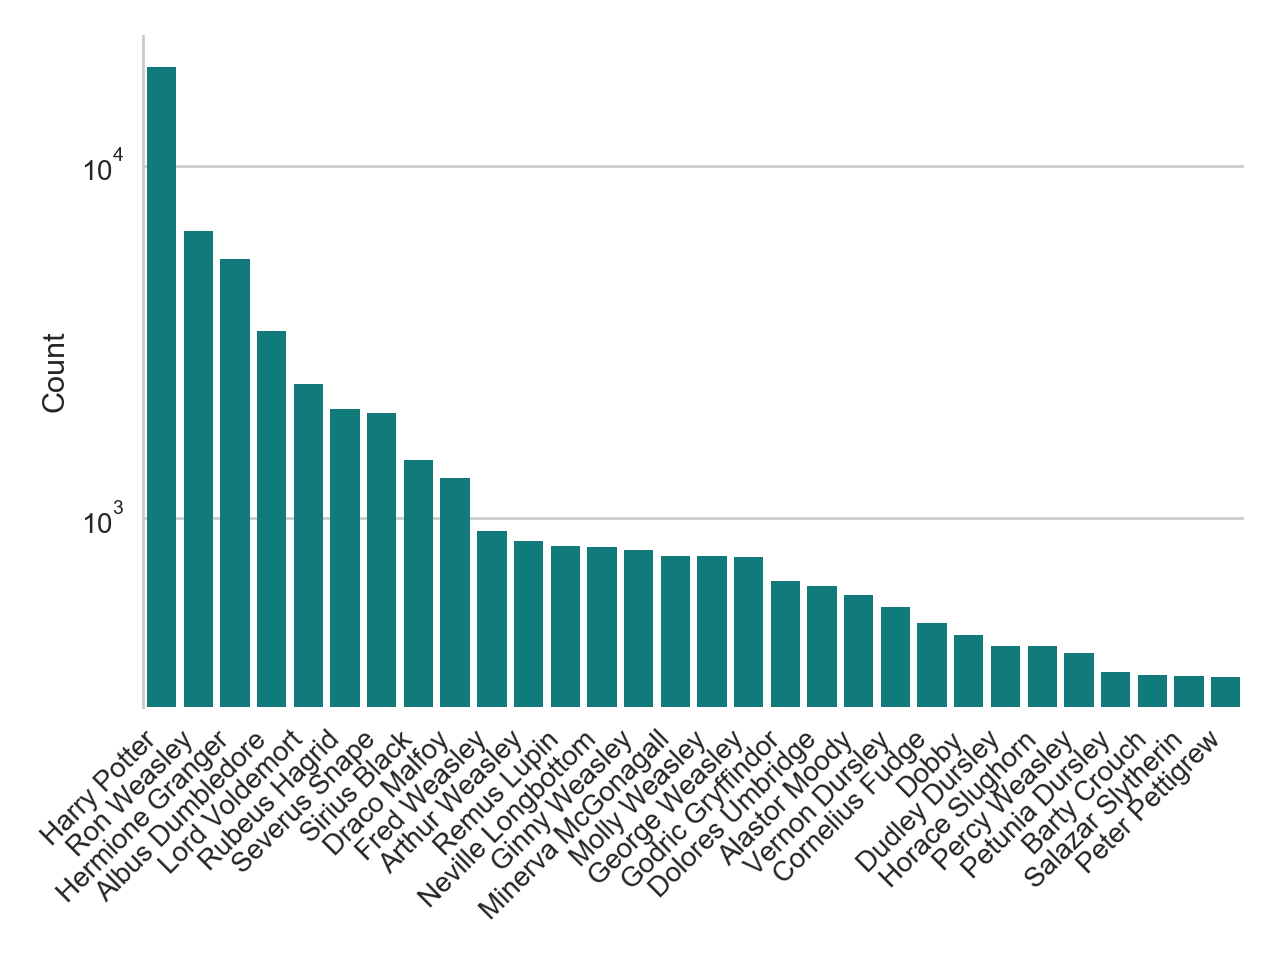

In [17]:
sns.set(style="whitegrid", context="notebook")

sort_character_count = character_count.sort_values(ascending=False)
sort_character_label = sort_character_count.index

# initialize plot
sns.barplot(sort_character_label.values[:30], sort_character_count[:30].values, color='DarkCyan')

# Finalize the plot
labels = plt.gca().get_xticklabels()
plt.setp(labels, rotation=45, ha='right')
plt.ylabel('Count')
plt.yscale('log')
sns.despine(bottom=True)
plt.tight_layout(h_pad=3)

Let's have a look at where selected characters appear in the text

In [ ]:
selected_characters = ['Harry Potter',
                       'Ron Weasley',
                       'Hermione Granger',
                       'Vernon Dursley',
                       'Sirius Black',
                       'Albus Dumbledore',
                       'Neville Longbottom',
                       'Dobby',
                       'Severus Snape',
                       'Horace Slughorn']

word_index = []
for c in selected_characters:
    wi = pd.DataFrame(hp.word_index[grouped_character[c]])
    wi['character'] = np.tile(c,wi.shape[0])
    word_index.append(wi)

# data frame with two columns. One that identifies the selected character, and another that identifies
#  where they appear
word_index = pd.concat(word_index, ignore_index=True)

<IPython.core.display.Javascript object>


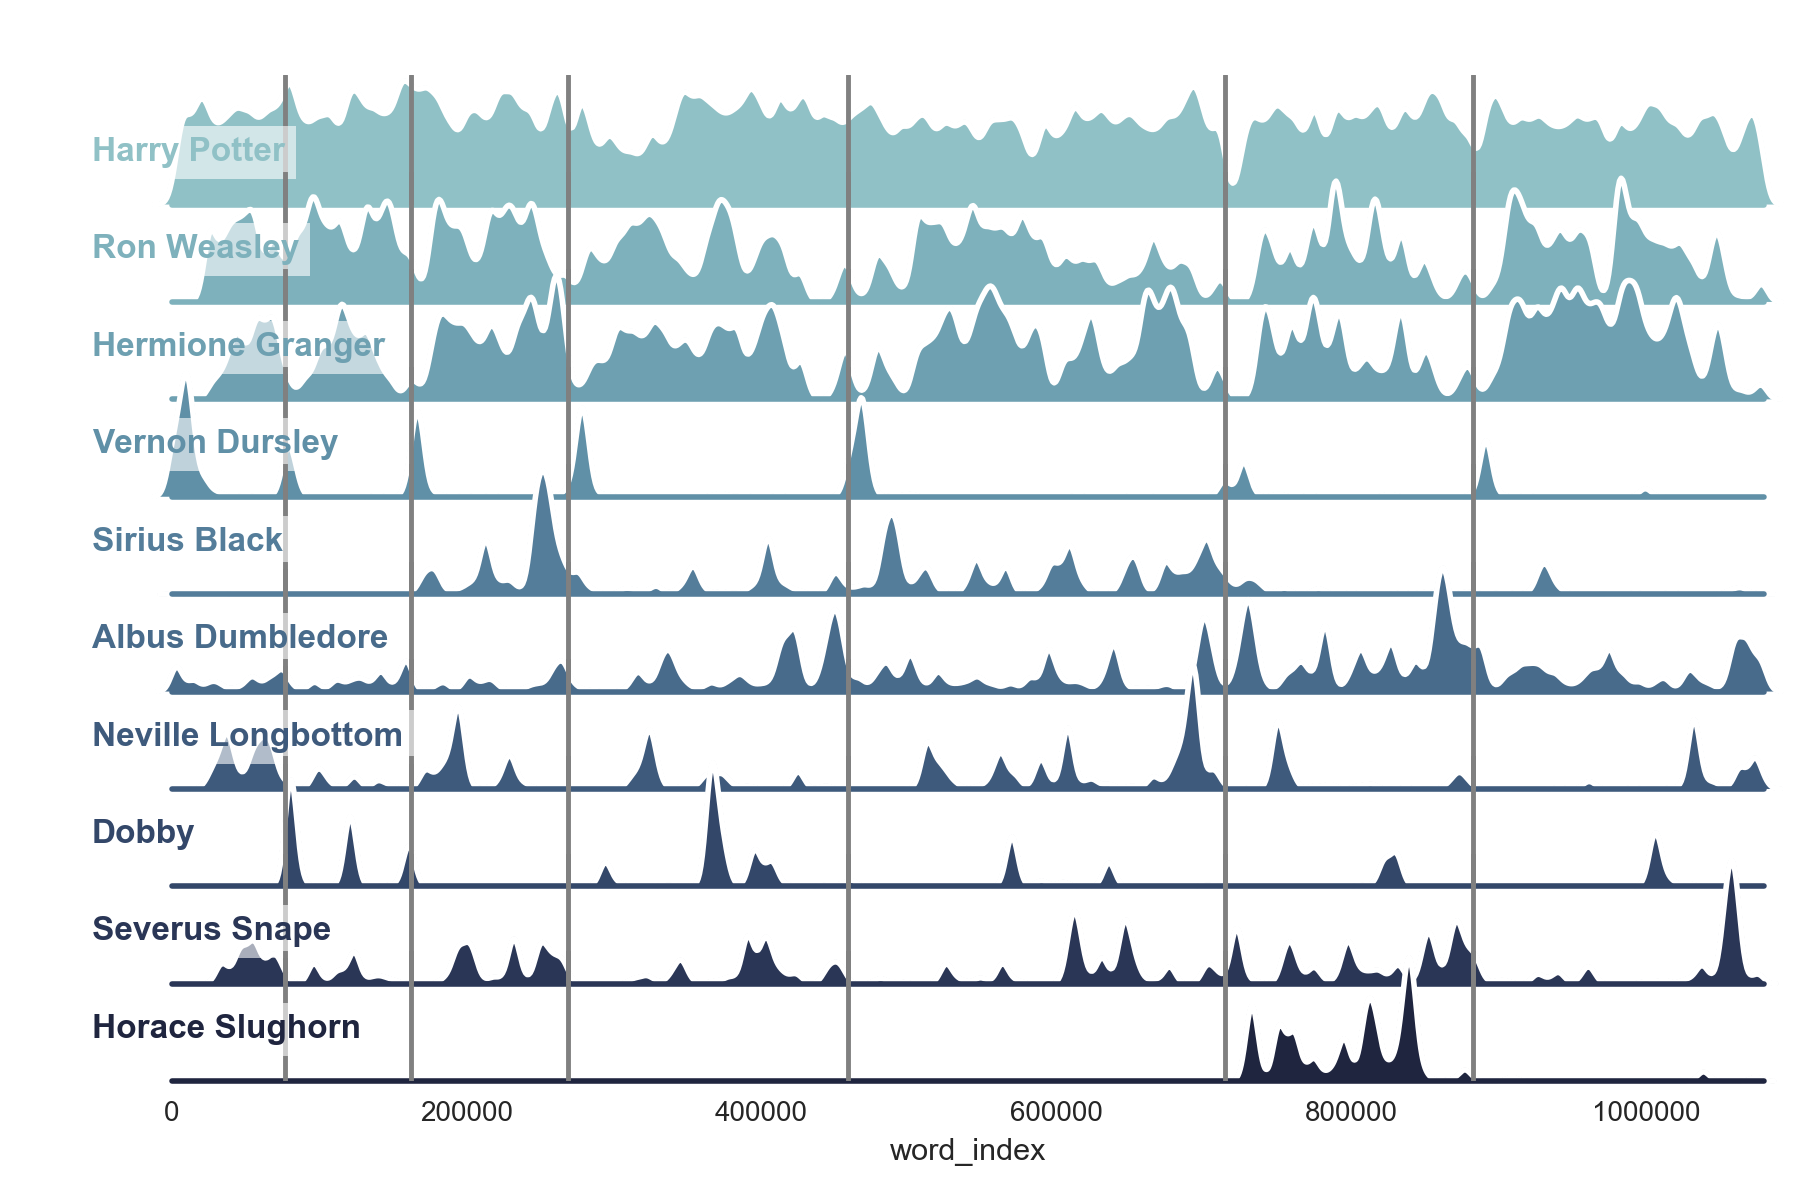

In [18]:
# determine the word index where the book changes
book_word_index = []
for i in range(1, 7):
    book_word_index.append(hp.word_index[hp.book_number == i].iloc[-1])

# initialize plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, context="notebook")
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(word_index, row='character', hue='character', aspect=15, size=0.6, sharey=False, palette=pal)
g.map(sns.kdeplot, 'word_index', clip_on=False, shade=True, alpha=1, lw=1.5, gridsize=1000, bw=4000)
g.map(sns.kdeplot, 'word_index', clip_on=False, color='w', lw=2, gridsize=1000, bw=4000)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
for bwi in book_word_index:
    g.map(plt.axvline, x=bwi, color='gray')

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    t = ax.text(-0.05, .4, label, fontweight="bold", color=color, 
                ha="left", va="center", transform=ax.transAxes, zorder=10)
    t.set_bbox(dict(alpha=0.6, facecolor='w', edgecolor='None'))

g.map(label, "word_index")

g.fig.subplots_adjust(hspace=-.25)

# Finalize
g.set_titles("")
g.set(xlim=(0,hp.word_index.iloc[-1]))
g.set(yticks=[])
g.despine(bottom=True, left=True)

What a plot. The vertical lines mark the book boundaries.

We can read many things from this plot. For example it is clear that Harry is all over all the time. The sole exception seems to be the dip at the beginning of Half-Blood-Prince; possibly due to the first chapter where he does not appear.

Ron and Hermione correlate a lot with each other signifying that the trio really is a trio. There are some differences however. Hermione only becomes friends with Harry and Ron in the middle of the first book, which can be seen on the plots. Also, Ron is missing at the end of Prisoner of Azkaban and halfway through Deathly Hallows.

Most other characters appear intermittently, perhaps most noticably Uncle Vernon and Dobby. Note how Uncle Vernon's appearances are closely correlated with the beginning of each book.

TO DO:
* Network analysis of the characters